In [223]:
#!L
from catboost import CatBoostRegressor, monoforest, Pool, cv
from catboost.utils import create_cd
from sklearn.datasets import load_diabetes
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, lasso_path
from sklearn.model_selection import train_test_split, GridSearchCV
from tqdm import tqdm as tqdm
from scipy import stats
from collections import defaultdict

In [2]:
#!L
import csv
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import pickle
import seaborn as sns
import sys
import warnings

In [13]:
#!L
%pip install seaborn

     |████████████████████████████████| 285 kB 2.5 MB/s 
     |████████████████████████████████| 11.6 MB 5.9 MB/s 
     |████████████████████████████████| 1.1 MB 7.1 MB/s 
     |████████████████████████████████| 14.8 MB 427 kB/s 
     |████████████████████████████████| 9.9 MB 11.2 MB/s 
     |████████████████████████████████| 2.2 MB 12.9 MB/s 
     |████████████████████████████████| 67 kB 5.4 MB/s 
     |████████████████████████████████| 227 kB 13.3 MB/s 
     |████████████████████████████████| 510 kB 13.0 MB/s 
     |████████████████████████████████| 27.4 MB 10.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mmdet 2.3.0rc0+c6b5ca2 requires Pillow<=6.2.2, but you have pillow 8.1.0 which is incompatible.
ml-kernel 0.0.1 requires setuptools<=50.3.2, but you have setuptools 51.1.1 which is incompatible.
You should consider upgrading via the '/usr/bin/pytho

In [3]:
#!L
PICKLE_DUMPS_PATH = os.path.join('resources', 'pickle_dumps')

def save_via_pickle(obj, filepath):
    with open(filepath, 'wb') as output_file:
        pickle.dump(obj, output_file)
        
def load_from_pickle(filepath):
    with open(filepath, 'rb') as input_file:
        return pickle.load(input_file)
    
def get_pickle_dump_path(dump_name):
    return os.path.join(PICKLE_DUMPS_PATH, f'{dump_name}.pkl')

In [22]:
#!L
diffs = {}
diffs['bootstrap'] = load_from_pickle(get_pickle_dump_path('diabetes_bootstrap_argset_diffs_240'))
diffs['~LightGBM'] = load_from_pickle(get_pickle_dump_path('diabetes_LightGBM_argset_diffs_240'))
diffs['empty'] = load_from_pickle(get_pickle_dump_path('diabetes_empty_argset_diffs_240'))
diffs['default'] = load_from_pickle(get_pickle_dump_path('diabetes_default_argset_diffs_240'))
diffs['border count 32'] = load_from_pickle(get_pickle_dump_path('diabetes_border_count_32_argset_diffs_240'))
diffs['border count 64'] = load_from_pickle(get_pickle_dump_path('diabetes_border_count_64_argset_diffs_240'))
diffs['border count 96'] = load_from_pickle(get_pickle_dump_path('diabetes_border_count_96_argset_diffs_240'))
diffs['border count 128'] = load_from_pickle(get_pickle_dump_path('diabetes_border_count_128_argset_diffs_240'))
diffs['border count 160'] = load_from_pickle(get_pickle_dump_path('diabetes_border_count_160_argset_diffs_240'))
diffs['border count 192'] = load_from_pickle(get_pickle_dump_path('diabetes_border_count_192_argset_diffs_240'))
diffs['border count 224'] = load_from_pickle(get_pickle_dump_path('diabetes_border_count_224_argset_diffs_240'))
diffs['border count 255'] = load_from_pickle(get_pickle_dump_path('diabetes_border_count_255_argset_diffs_240'))

In [92]:
#!L
diffs['default without best iterations'] = load_from_pickle(get_pickle_dump_path('default_without_best_iteration_diffs_240'))

In [29]:
#!L
diffs.keys()

dict_keys(['bootstrap', '~LightGBM', 'empty', 'default', 'border count 32', 'border count 64', 'border count 96', 'border count 128', 'border count 160', 'border count 192', 'border count 224', 'border count 255'])

In [44]:
#!L
default_diffs = diffs['default'][:25]
results = []
for key in diffs.keys():
    if key == 'default':
        continue
    results.append({})
    current_diffs = diffs[key][:25]
    print(f'{key} argset')
    print('Two-sided tests')
    results[-1]['First model'] = 'default'
    results[-1]['Second model'] = key
    w, p_value = stats.wilcoxon(default_diffs, current_diffs, alternative='two-sided', mode='exact')
    results[-1]['Two-sided, 25'] = p_value
    print(f'Default argset vs {key} argset, 25 values, Wilcoxon test p-value: {p_value}, statistic: {w}')
    w, p_value = stats.wilcoxon(diffs['default'], diffs[key])
    results[-1]['Two-sided, 240'] = p_value
    print(f'Default argset vs {key} argset, all values, Wilcoxon test p-value: {p_value}, statistic: {w}')
    print(f'One-sided tests: median(\'default\' - \'{key}\' is positive)')
    w, p_value = stats.wilcoxon(default_diffs, current_diffs, alternative='greater', mode='exact')
    results[-1]['One-sided, 25'] = p_value
    print(f'Default argset vs {key} argset, 25 values, Wilcoxon test p-value: {p_value}, statistic: {w}')
    w, p_value = stats.wilcoxon(diffs['default'], diffs[key], alternative='greater')
    results[-1]['One-sided, 240'] = p_value
    print(f'Default argset vs {key} argset, all values, Wilcoxon test p-value: {p_value}, statistic: {w}')
    print()

bootstrap argset
Two-sided tests
Default argset vs bootstrap argset, 25 values, Wilcoxon test p-value: 1.8298625946044922e-05, statistic: 19.0
Default argset vs bootstrap argset, all values, Wilcoxon test p-value: 1.5875089696418545e-23, statistic: 3751.0
One-sided tests: median('default' - 'bootstrap' is positive)
Default argset vs bootstrap argset, 25 values, Wilcoxon test p-value: 0.9999924600124359, statistic: 19.0
Default argset vs bootstrap argset, all values, Wilcoxon test p-value: 1.0, statistic: 3751.0

~LightGBM argset
Two-sided tests
Default argset vs ~LightGBM argset, 25 values, Wilcoxon test p-value: 0.3665854334831238, statistic: 128.0
Default argset vs ~LightGBM argset, all values, Wilcoxon test p-value: 0.6910987292710071, statistic: 14150.0
One-sided tests: median('default' - '~LightGBM' is positive)
Default argset vs ~LightGBM argset, 25 values, Wilcoxon test p-value: 0.8237401843070984, statistic: 128.0
Default argset vs ~LightGBM argset, all values, Wilcoxon test p-

In [52]:
#!L
print(os.linesep.join([str(result['One-sided, 25']) for result in results]))

0.9999924600124359
0.8237401843070984
0.10999318957328796
0.14361464977264404
0.6345053911209106
0.09086492657661438
0.3360375761985779
0.19049182534217834
0.6144202947616577
0.8237401843070984
0.8237401843070984


In [56]:
#!L
for key, diffs1 in diffs.items():
    correlations = []
    for second_key, diffs2 in diffs.items():
        correlations.append((second_key, stats.pearsonr(diffs1, diffs2)[0]))
    correlations.sort(key=lambda x: x[0])
    print(key)
    print(os.linesep.join([str(corr[1]) for corr in correlations]))
    print(os.linesep.join([corr[0] for corr in correlations]))
    print()

bootstrap
1.0
0.22963869175192675
0.22111783894630183
0.2427262430072845
0.23470221625047263
0.23470221625047263
0.281571907265297
0.17405730305284803
0.18332146474918679
0.24665794333884475
0.15576467121392362
0.23470221625047263
bootstrap
border count 128
border count 160
border count 192
border count 224
border count 255
border count 32
border count 64
border count 96
default
empty
~LightGBM

~LightGBM
0.23470221625047263
0.8092801553650384
0.8833811707582003
0.9683878200568593
1.0
1.0
0.5734801106251974
0.6142420335157097
0.6384980358294536
0.9356942731898966
0.5367101088393159
1.0
bootstrap
border count 128
border count 160
border count 192
border count 224
border count 255
border count 32
border count 64
border count 96
default
empty
~LightGBM

empty
0.15576467121392362
0.47057652316148657
0.5285821505219656
0.5443441271176704
0.5367101088393159
0.5367101088393159
0.38107627533673505
0.5030471932052726
0.43403138318349593
0.5385846287937043
1.0
0.5367101088393159
bootstrap
border

In [23]:
#!L
for key, diffs1 in diffs.items():
    for second_key, diffs2 in diffs.items():
        if key == second_key:
            continue
        print(f'{key} argset and {second_key} argset correlation: {stats.pearsonr(diffs1, diffs2)[0]}')
    print()

bootstrap argset and ~LightGBM argset correlation: 0.23470221625047263
bootstrap argset and empty argset correlation: 0.15576467121392362
bootstrap argset and default argset correlation: 0.24665794333884475
bootstrap argset and border count 32 argset correlation: 0.281571907265297
bootstrap argset and border count 64 argset correlation: 0.17405730305284803
bootstrap argset and border count 96 argset correlation: 0.18332146474918679
bootstrap argset and border count 128 argset correlation: 0.22963869175192675
bootstrap argset and border count 160 argset correlation: 0.22111783894630183
bootstrap argset and border count 192 argset correlation: 0.2427262430072845
bootstrap argset and border count 224 argset correlation: 0.23470221625047263
bootstrap argset and border count 255 argset correlation: 0.23470221625047263

~LightGBM argset and bootstrap argset correlation: 0.23470221625047263
~LightGBM argset and empty argset correlation: 0.5367101088393159
~LightGBM argset and default argset c

In [ ]:
#!L
default_diffs = diffs['default'][:25]
results = []
for key in diffs.keys():
    if key == 'default':
        continue
    results.append({})
    current_diffs = diffs[key][:25]
    print(f'{key} argset')
    print('Two-sided tests')
    results[-1]['First model'] = 'default'
    results[-1]['Second model'] = key
    w, p_value = stats.wilcoxon(default_diffs, current_diffs, alternative='two-sided', mode='exact')
    results[-1]['Two-sided, 25'] = p_value
    print(f'Default argset vs {key} argset, 25 values, Wilcoxon test p-value: {p_value}, statistic: {w}')
    w, p_value = stats.wilcoxon(diffs['default'], diffs[key])
    results[-1]['Two-sided, 240'] = p_value
    print(f'Default argset vs {key} argset, all values, Wilcoxon test p-value: {p_value}, statistic: {w}')
    print(f'One-sided tests: median(\'default\' - \'{key}\' is positive)')
    w, p_value = stats.wilcoxon(default_diffs, current_diffs, alternative='greater', mode='exact')
    results[-1]['One-sided, 25'] = p_value
    print(f'Default argset vs {key} argset, 25 values, Wilcoxon test p-value: {p_value}, statistic: {w}')
    w, p_value = stats.wilcoxon(diffs['default'], diffs[key], alternative='greater')
    results[-1]['One-sided, 240'] = p_value
    print(f'Default argset vs {key} argset, all values, Wilcoxon test p-value: {p_value}, statistic: {w}')
    print()

In [105]:
#!L
default_diffs = diffs['bootstrap'][:25]
results = []
for key in diffs.keys():
    if key == 'bootstrap':
        continue
    results.append({})
    current_diffs = diffs[key][:25]
    print(f'{key} argset')
    print('Two-sided tests')
    results[-1]['First model'] = 'bootstrap'
    results[-1]['Second model'] = key
    w, p_value = stats.wilcoxon(default_diffs, current_diffs, alternative='two-sided', mode='exact')
    results[-1]['Two-sided, 25'] = p_value
    print(f'bootstrap argset vs {key} argset, 25 values, Wilcoxon test p-value: {p_value}, statistic: {w}')
    w, p_value = stats.wilcoxon(diffs['bootstrap'], diffs[key])
    results[-1]['Two-sided, 240'] = p_value
    print(f'bootstrap argset vs {key} argset, all values, Wilcoxon test p-value: {p_value}, statistic: {w}')
    print(f'One-sided tests: median(\'bootstrap\' - \'{key}\' is positive)')
    w, p_value = stats.wilcoxon(default_diffs, current_diffs, alternative='less', mode='exact')
    results[-1]['One-sided, 25'] = p_value
    print(f'bootstrap argset vs {key} argset, 25 values, Wilcoxon test p-value: {p_value}, statistic: {w}')
    w, p_value = stats.wilcoxon(diffs['bootstrap'], diffs[key], alternative='less')
    results[-1]['One-sided, 240'] = p_value
    print(f'bootstrap argset vs {key} argset, all values, Wilcoxon test p-value: {p_value}, statistic: {w}')
    print()

~LightGBM argset
Two-sided tests
bootstrap argset vs ~LightGBM argset, 25 values, Wilcoxon test p-value: 3.1948089599609375e-05, statistic: 22.0
bootstrap argset vs ~LightGBM argset, all values, Wilcoxon test p-value: 3.185401980348059e-23, statistic: 3826.0
One-sided tests: median('bootstrap' - '~LightGBM' is positive)
bootstrap argset vs ~LightGBM argset, 25 values, Wilcoxon test p-value: 0.9999866783618927, statistic: 303.0
bootstrap argset vs ~LightGBM argset, all values, Wilcoxon test p-value: 1.0, statistic: 25335.0

empty argset
Two-sided tests
bootstrap argset vs empty argset, 25 values, Wilcoxon test p-value: 1.233816146850586e-05, statistic: 17.0
bootstrap argset vs empty argset, all values, Wilcoxon test p-value: 7.612120704396165e-26, statistic: 3192.0
One-sided tests: median('bootstrap' - 'empty' is positive)
bootstrap argset vs empty argset, 25 values, Wilcoxon test p-value: 0.9999949634075165, statistic: 308.0
bootstrap argset vs empty argset, all values, Wilcoxon test p

In [69]:
#!L
default_diffs = diffs['~LightGBM'][:25]
results = []
for key in diffs.keys():
    if key == '~LightGBM':
        continue
    results.append({})
    current_diffs = diffs[key][:25]
    print(f'{key} argset')
    print('Two-sided tests')
    results[-1]['First model'] = '~LightGBM'
    results[-1]['Second model'] = key
    try:
        w, p_value = stats.wilcoxon(default_diffs, current_diffs, alternative='two-sided', mode='exact')
    except:
        w, p_value = 0, 1
    results[-1]['Two-sided, 25'] = p_value
    print(f'~LightGBM argset vs {key} argset, 25 values, Wilcoxon test p-value: {p_value}, statistic: {w}')
    try:
        w, p_value = stats.wilcoxon(diffs['~LightGBM'], diffs[key])
    except:
        w, p_value = 0, 1
    results[-1]['Two-sided, 240'] = p_value
    print(f'~LightGBM argset vs {key} argset, all values, Wilcoxon test p-value: {p_value}, statistic: {w}')
    print(f'One-sided tests: median(\'~LightGBM\' - \'{key}\' is positive)')
    try:
        w, p_value = stats.wilcoxon(default_diffs, current_diffs, alternative='greater', mode='exact')
    except:
        w, p_value = 0, 0
    results[-1]['One-sided, 25'] = p_value
    print(f'~LightGBM argset vs {key} argset, 25 values, Wilcoxon test p-value: {p_value}, statistic: {w}')
    try:
        w, p_value = stats.wilcoxon(diffs['~LightGBM'], diffs[key], alternative='greater')
    except:
        w, p_value = 0, 0
    results[-1]['One-sided, 240'] = p_value
    print(f'~LightGBM argset vs {key} argset, all values, Wilcoxon test p-value: {p_value}, statistic: {w}')
    print()

bootstrap argset
Two-sided tests
~LightGBM argset vs bootstrap argset, 25 values, Wilcoxon test p-value: 3.1948089599609375e-05, statistic: 22.0
~LightGBM argset vs bootstrap argset, all values, Wilcoxon test p-value: 3.185401980348059e-23, statistic: 3826.0
One-sided tests: median('~LightGBM' - 'bootstrap' is positive)
~LightGBM argset vs bootstrap argset, 25 values, Wilcoxon test p-value: 0.9999866783618927, statistic: 22.0
~LightGBM argset vs bootstrap argset, all values, Wilcoxon test p-value: 1.0, statistic: 3826.0

empty argset
Two-sided tests
~LightGBM argset vs empty argset, 25 values, Wilcoxon test p-value: 0.10139739513397217, statistic: 101.0
~LightGBM argset vs empty argset, all values, Wilcoxon test p-value: 0.004742682960116934, statistic: 11521.0
One-sided tests: median('~LightGBM' - 'empty' is positive)
~LightGBM argset vs empty argset, 25 values, Wilcoxon test p-value: 0.050698697566986084, statistic: 224.0
~LightGBM argset vs empty argset, all values, Wilcoxon test p-

/home/jupyter/work/pyenv/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/jupyter/work/pyenv/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/jupyter/work/pyenv/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/jupyter/work/pyenv/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/jupyter/work/pyenv/scipy/stats/morestats.py:2957: User

In [75]:
#!L
print(os.linesep.join([str(result['One-sided, 240']) for result in results]))

1.0
0.002371341480058467
0.34554936463550356
4.7316555742117085e-05
0.0010264902840726646
0.0031591888538776013
0.030387035900168956
0.14430518555033106
0.742557417317687
0
0


In [100]:
#!L
default_diffs = diffs['default'][:25]
results = []
for key in diffs.keys():
    if key == 'default':
        continue
    results.append({})
    current_diffs = diffs[key][:25]
    print(f'{key} argset')
    print('Two-sided tests')
    results[-1]['First model'] = 'default'
    results[-1]['Second model'] = key
    w, p_value = stats.wilcoxon(default_diffs, current_diffs, alternative='two-sided', mode='exact')
    results[-1]['Two-sided, 25'] = p_value
    print(f'Default argset vs {key} argset, 25 values, Wilcoxon test p-value: {p_value}, statistic: {w}')
    w, p_value = stats.wilcoxon(diffs['default'], diffs[key])
    results[-1]['Two-sided, 240'] = p_value
    print(f'Default argset vs {key} argset, all values, Wilcoxon test p-value: {p_value}, statistic: {w}')
    print(f'One-sided tests: median(\'default\' - \'{key}\' is positive)')
    w, p_value = stats.wilcoxon(default_diffs, current_diffs, alternative='greater', mode='exact')
    results[-1]['One-sided, 25'] = p_value
    print(f'Default argset vs {key} argset, 25 values, Wilcoxon test p-value: {p_value}, statistic: {w}')
    w, p_value = stats.wilcoxon(diffs['default'], diffs[key], alternative='greater')
    results[-1]['One-sided, 240'] = p_value
    print(f'Default argset vs {key} argset, all values, Wilcoxon test p-value: {p_value}, statistic: {w}')
    print()

bootstrap argset
Two-sided tests
Default argset vs bootstrap argset, 25 values, Wilcoxon test p-value: 1.8298625946044922e-05, statistic: 19.0
Default argset vs bootstrap argset, all values, Wilcoxon test p-value: 1.5875089696418545e-23, statistic: 3751.0
One-sided tests: median('default' - 'bootstrap' is positive)
Default argset vs bootstrap argset, 25 values, Wilcoxon test p-value: 0.9999924600124359, statistic: 19.0
Default argset vs bootstrap argset, all values, Wilcoxon test p-value: 1.0, statistic: 3751.0

~LightGBM argset
Two-sided tests
Default argset vs ~LightGBM argset, 25 values, Wilcoxon test p-value: 0.3665854334831238, statistic: 128.0
Default argset vs ~LightGBM argset, all values, Wilcoxon test p-value: 0.6910987292710071, statistic: 14150.0
One-sided tests: median('default' - '~LightGBM' is positive)
Default argset vs ~LightGBM argset, 25 values, Wilcoxon test p-value: 0.8237401843070984, statistic: 128.0
Default argset vs ~LightGBM argset, all values, Wilcoxon test p-

In [104]:
#!L
print(os.linesep.join([str(result['Two-sided, 240']) for result in results]))

1.5875089696418545e-23
0.6910987292710071
0.0009376325813599984
3.944367796875008e-05
0.0012696210355790337
0.0058731027994309674
0.04385896822163693
0.42865327468848
0.9121697967839073
0.6910987292710071
0.6910987292710071
0.005303252410723073


In [106]:
#!L
np.mean(diffs['bootstrap'])

3.2735725937128057

In [107]:
#!L
np.mean(diffs['default'])

0.7078175024710792

In [131]:
#!L
fixed_diffs = {}
fixed_diffs['bootstrap'] = load_from_pickle(get_pickle_dump_path('fixed_bootstrap_argset_diffs_199'))
fixed_diffs['~LightGBM'] = load_from_pickle(get_pickle_dump_path('fioxed_LightGBM_argset_diffs_199'))
fixed_diffs['empty'] = load_from_pickle(get_pickle_dump_path('fixed_diabetes_empty_argset_199'))
fixed_diffs['default'] = load_from_pickle(get_pickle_dump_path('fixed_default_argset_diffs_199'))

/home/jupyter/work/pyenv/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rmse diff', ylabel='Density'>

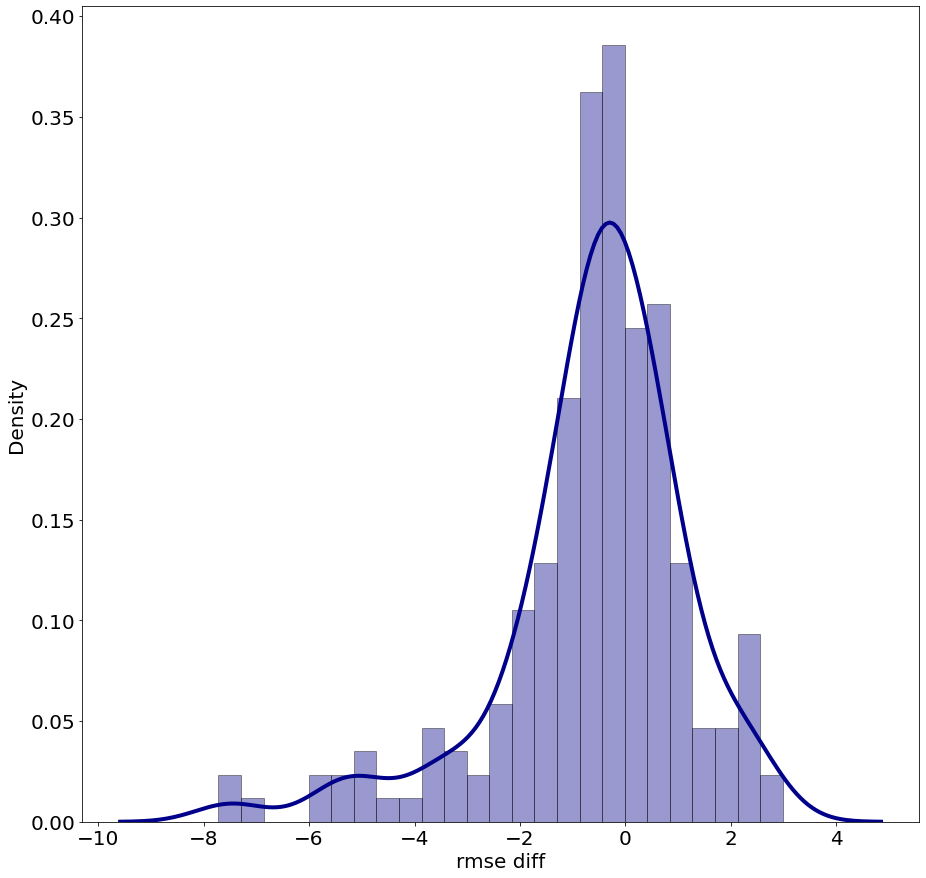

In [200]:
#!L
plt.rcParams.update({ 'figure.figsize' : (15, 15), 'font.size' : 20 })
sns.distplot(fixed_diffs['default'], hist=True, kde=True, 
             bins=25, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
             axlabel='rmse diff')

/home/jupyter/work/pyenv/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rmse diff', ylabel='Density'>

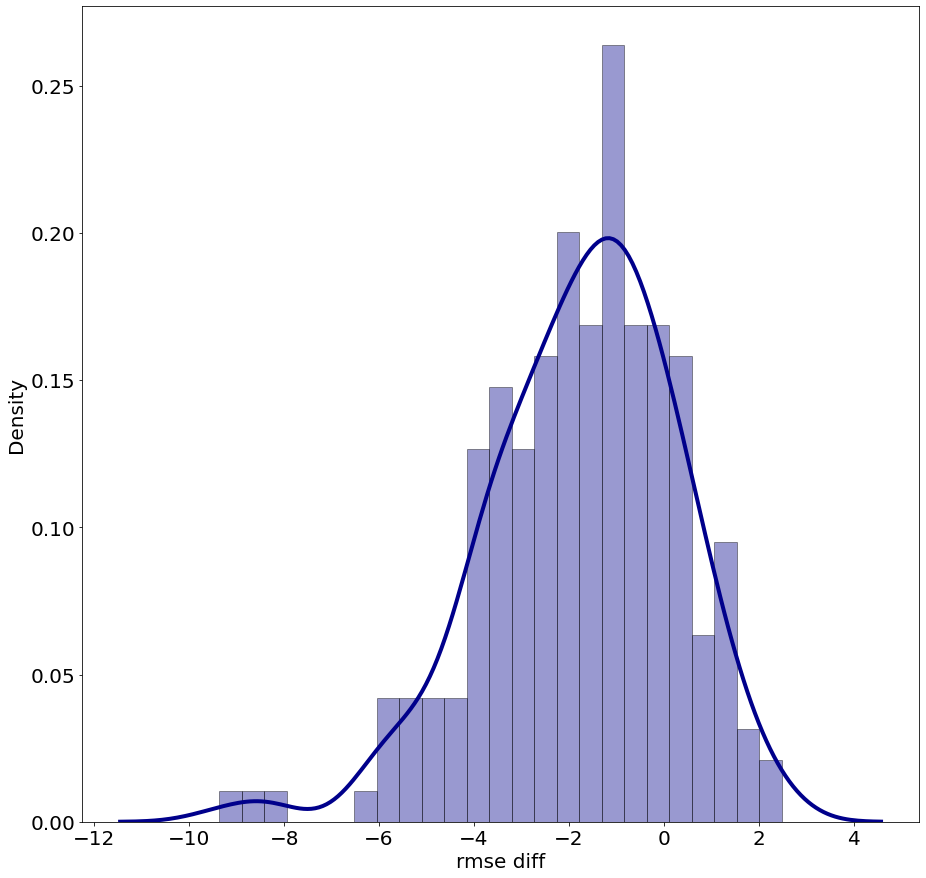

In [201]:
#!L
plt.rcParams.update({ 'figure.figsize' : (15, 15), 'font.size' : 20 })
sns.distplot(fixed_diffs['bootstrap'], hist=True, kde=True, 
             bins=25, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
             axlabel='rmse diff')

/home/jupyter/work/pyenv/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rmse diff', ylabel='Density'>

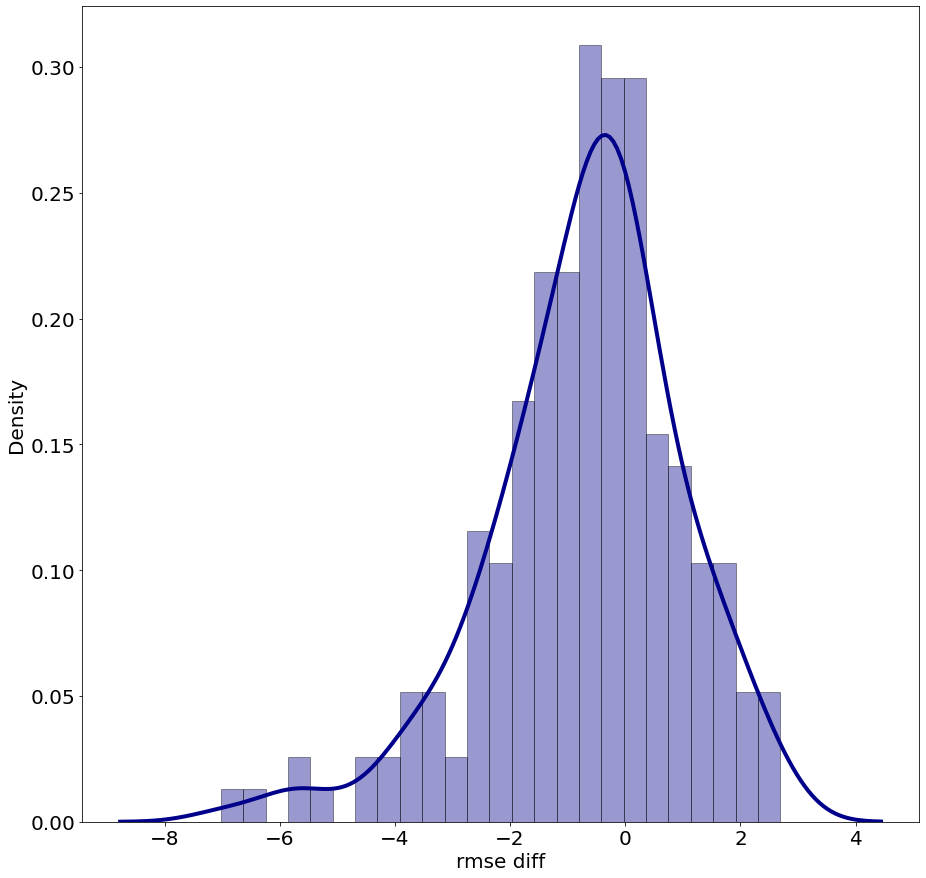

In [202]:
#!L
plt.rcParams.update({ 'figure.figsize' : (15, 15), 'font.size' : 20 })
sns.distplot(fixed_diffs['empty'], hist=True, kde=True, 
             bins=25, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
             axlabel='rmse diff')

/home/jupyter/work/pyenv/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rmse diff', ylabel='Density'>

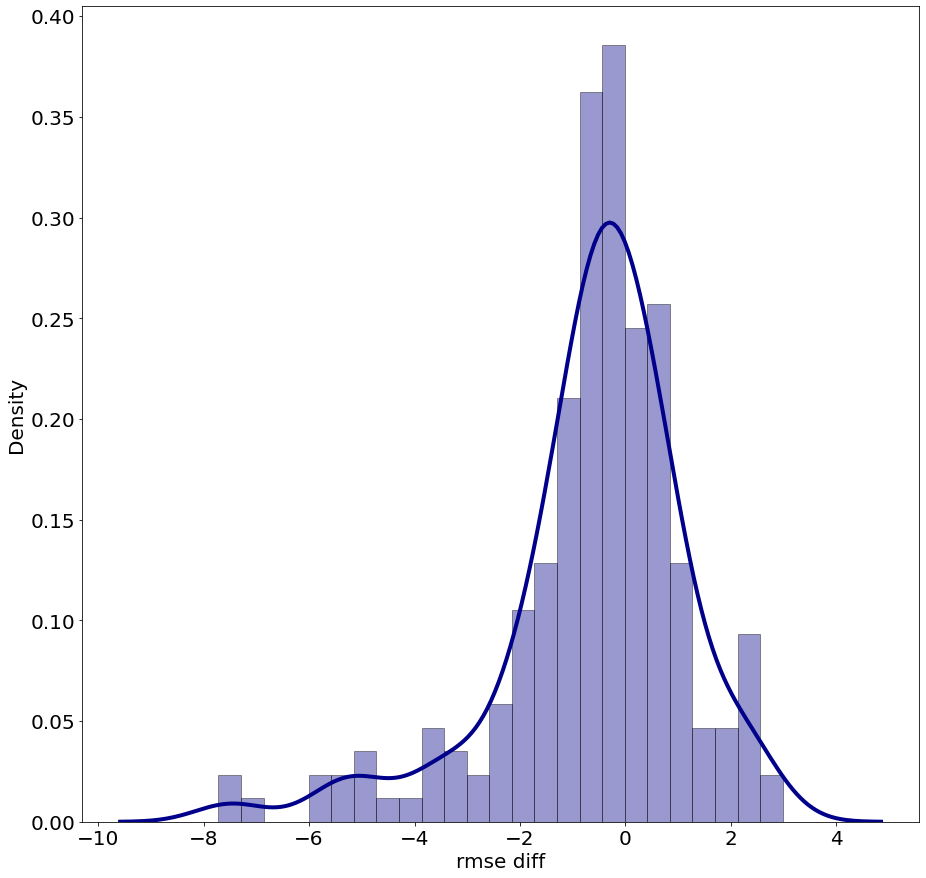

In [203]:
#!L
plt.rcParams.update({ 'figure.figsize' : (15, 15), 'font.size' : 20 })
sns.distplot(fixed_diffs['~LightGBM'], hist=True, kde=True, 
             bins=25, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
             axlabel='rmse diff')

In [137]:
#!L
for key, diffs1 in fixed_diffs.items():
    correlations = []
    for second_key, diffs2 in fixed_diffs.items():
        correlations.append((second_key, stats.pearsonr(diffs1, diffs2)[0]))
    correlations.sort(key=lambda x: x[0])
    print(key)
    print(os.linesep.join([str(corr[1]) for corr in correlations]))
    print(os.linesep.join([corr[0] for corr in correlations]))
    print()

bootstrap
1.0
0.0940686829541296
0.09103529463982142
0.0940686829541296
bootstrap
default
empty
~LightGBM

~LightGBM
0.0940686829541296
1.0
0.07438314544862731
1.0
bootstrap
default
empty
~LightGBM

empty
0.09103529463982142
0.07438314544862731
1.0
0.07438314544862731
bootstrap
default
empty
~LightGBM

default
0.0940686829541296
1.0
0.07438314544862731
1.0
bootstrap
default
empty
~LightGBM



In [140]:
#!L
results = []
for first_key, first_diff in fixed_diffs.items():
    for second_key, second_diff in fixed_diffs.items():
        if first_key != second_key:
            if not np.any(np.array(first_diff) - np.array(second_diff)):
                results.append((first_key, second_key, 'EQUAL', 'EQUAL', 'EQUAL'))
                continue
            p_zero = stats.wilcoxon(first_diff, second_diff, alternative='two-sided')[1]
            p_greater = stats.wilcoxon(first_diff, second_diff, alternative='less')[1]
            p_less = stats.wilcoxon(first_diff, second_diff, alternative='greater')[1]
            results.append((first_key, second_key, p_zero, p_greater, p_less))

In [145]:
#!L
print(os.linesep.join(list(map(str, [r[4] for r in results]))))

0.9999999998083651
0.9999999922848459
0.9999999998083651
1.9163494297447192e-10
0.05179351151630722
EQUAL
7.715154052172372e-09
0.9482064884836928
0.9482064884836928
1.9163494297447192e-10
EQUAL
0.05179351151630722


In [152]:
#!L
print(5, np.percentile(np.array(fixed_diffs['default']), 5))
print(50, np.percentile(np.array(fixed_diffs['default']), 50))
print(95, np.percentile(np.array(fixed_diffs['default']), 95))

5 -4.55528388228565
50 -0.38648219772802506
95 2.006714687394971


In [153]:
#!L
print(5, np.percentile(np.array(fixed_diffs['bootstrap']), 5))
print(50, np.percentile(np.array(fixed_diffs['bootstrap']), 50))
print(95, np.percentile(np.array(fixed_diffs['bootstrap']), 95))

5 -5.170842707078105
50 -1.5694198501638148
95 1.1370118221337526


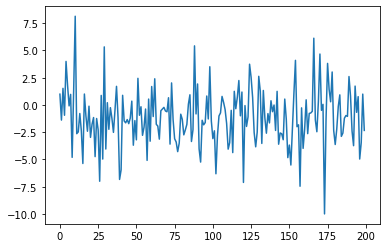

In [154]:
#!L
plt.clf()
plt.plot(np.array(fixed_diffs['bootstrap']) - np.array(fixed_diffs['default']))

In [291]:
#!L
import pandas as pd

LOGS_PATH = os.path.join('resources', 'logs')

def load_log(log_name):
    return pd.read_csv(os.path.join(LOGS_PATH, f'{log_name}.log'))

In [155]:
#!L
constant_scores = load_from_pickle(get_pickle_dump_path('constant_scores'))

In [169]:
#!L
bootstrap_log = load_log('fixed_bootstrap_argset_diffs')
default_log = load_log('fixed_default_argset_diffs')

/home/jupyter/work/pyenv/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rmse diff', ylabel='Density'>

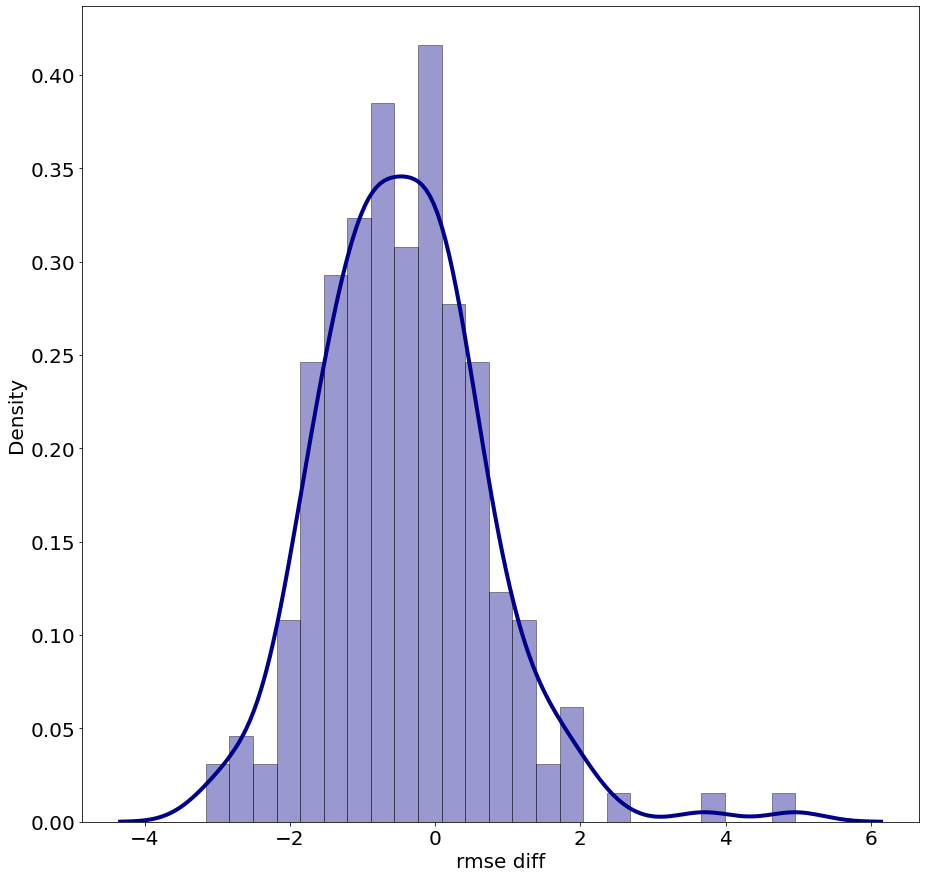

In [206]:
#!L
sns.distplot(bootstrap_log['test reg rmse'] - default_log['test reg rmse'], hist=True, kde=True, 
             bins=25, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
             axlabel='rmse diff')

In [168]:
#!L
bootstrap_log

,tree count,best lambda,best iter,train reg rmse,train lasso rmse,val reg rmse,val lasso rmse,test reg rmse,test lasso rmse
0,110,2.824752,3,48.327106,49.213485,56.976701,57.178505,61.420535,59.712043
1,164,1.977327,9,44.905457,44.714211,59.162981,57.833021,61.506974,63.140835
2,372,1.384129,63,44.298579,43.616097,55.560330,56.663224,54.043992,54.798363
3,439,1.977327,3,45.063773,48.981623,52.725860,53.149989,50.347257,51.092311
4,31,11.764900,5,58.016462,60.950124,61.252536,62.725419,65.259457,68.808825
...,...,...,...,...,...,...,...,...,...
195,364,1.384129,47,43.628910,43.010563,56.855173,57.439551,53.419940,53.172012
196,305,1.384129,7,45.496968,44.479156,49.627486,50.697367,59.734229,63.925055
197,95,5.764801,36,51.517718,54.789953,61.718646,62.464129,51.558111,54.277401
198,502,1.977327,57,42.429219,46.256881,58.383180,62.130247,52.357110,52.538104


/home/jupyter/work/pyenv/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rmse diff', ylabel='Density'>

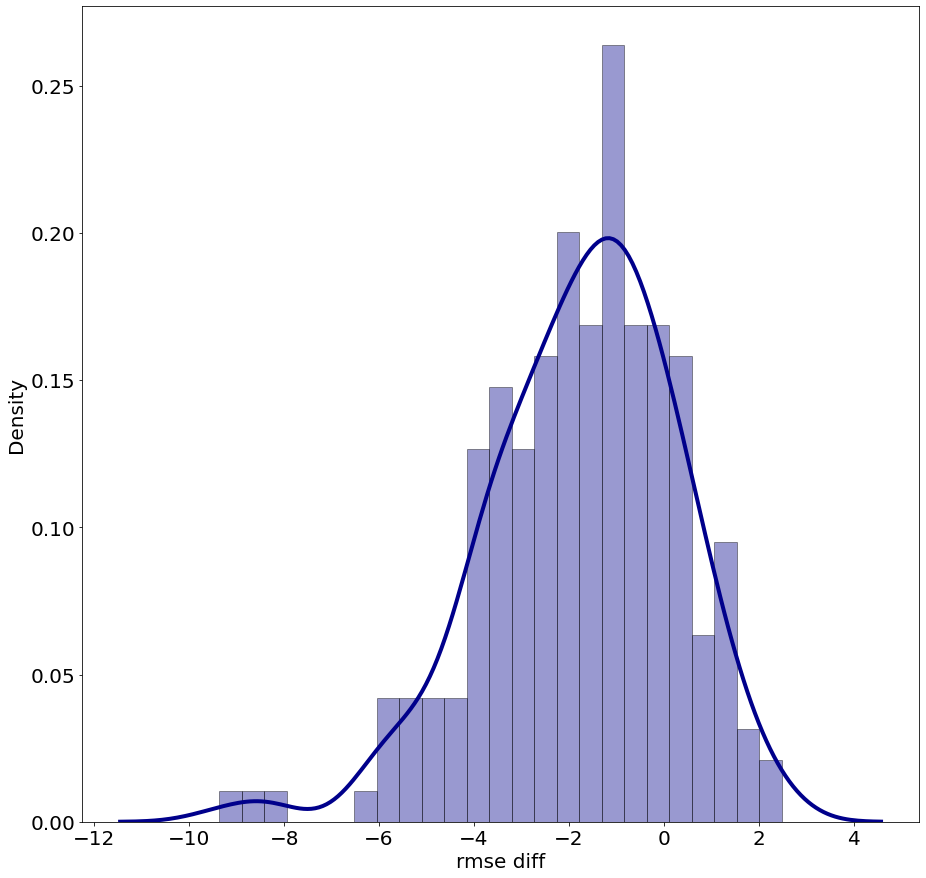

In [199]:
#!L
plt.rcParams.update({ 'figure.figsize' : (15, 15), 'font.size' : 20 })
sns.distplot(bootstrap_log['test reg rmse'] - bootstrap_log['test lasso rmse'], hist=True, kde=True, 
             bins=25, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
             axlabel='rmse diff')

In [175]:
#!L
fixed_diffs['bernoulli bootstrap'] = load_from_pickle(get_pickle_dump_path('fixed_bernoulli_bootstrap_argset_diffs_40'))

/home/jupyter/work/pyenv/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rmse diff', ylabel='Density'>

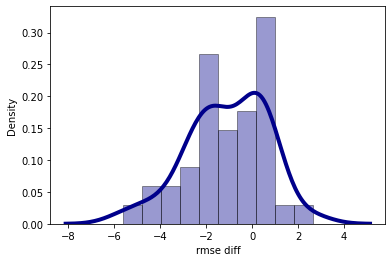

In [177]:
#!L
sns.distplot(fixed_diffs['bernoulli bootstrap'], hist=True, kde=True, 
             bins=10, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
             axlabel='rmse diff')

In [178]:
#!L
stats.pearsonr(fixed_diffs['bernoulli bootstrap'], fixed_diffs['bootstrap'][:41])[0]

0.45413800072233274

In [187]:
#!L
log_names = [('fioxed_LightGBM_argset_diffs', '~LightGBM'), ('fixed_bootstrap_argset_diffs', 'bootstrap'), 
             ('fixed_default_argset_diffs', 'default'), ('fixed_diabetes_empty_argset', 'empty')]
logs = {key_name: load_log(name) for name, key_name in log_names}

In [192]:
#!L
log_results = []
for first_key, first_log in logs.items():
    for second_key, second_log in logs.items():
        lasso_diff = first_log['test lasso rmse'] - second_log['test lasso rmse']
        reg_diff = first_log['test reg rmse'] - second_log['test reg rmse']
        corr = stats.pearsonr(lasso_diff, reg_diff)[0]
        log_results.append((first_key, second_key, corr))

False False
True True
False False
True True
True True
False False
True True
True True
False False
True True
False False
True True
True True
True True
True True
False False


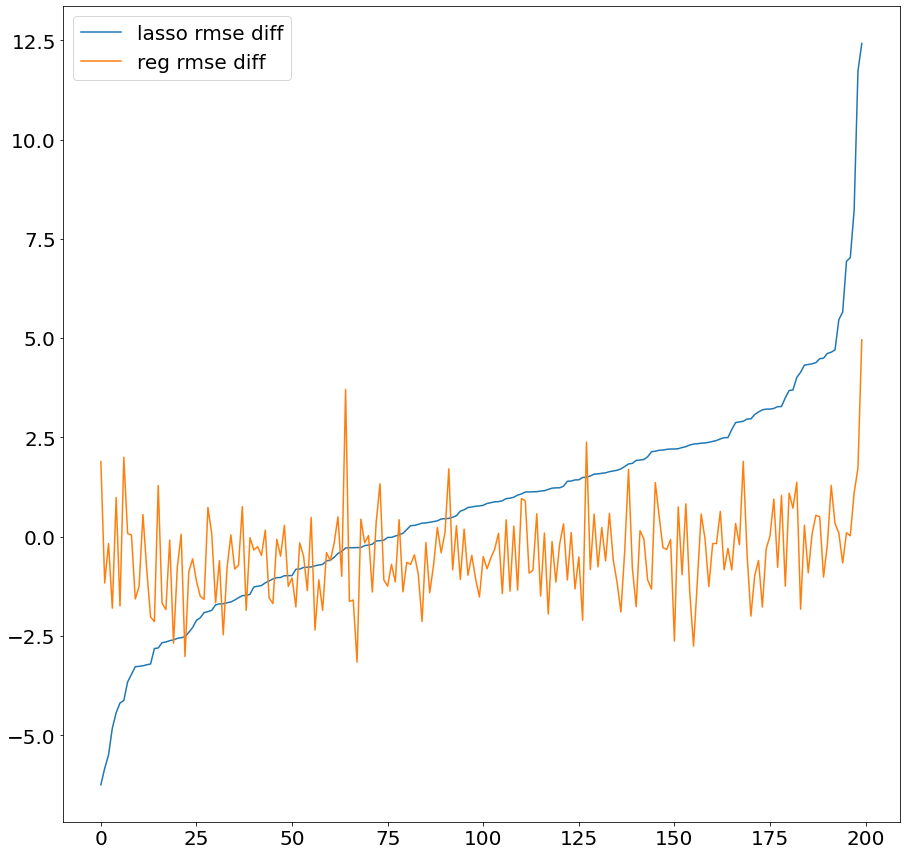

In [213]:
#!L
plt.rcParams.update({ 'figure.figsize' : (15, 15), 'font.size' : 20 })
plt.clf()
lasso_diff = (logs['bootstrap']['test lasso rmse'] - logs['default']['test lasso rmse']).to_numpy()
reg_diff = (logs['bootstrap']['test reg rmse'] - logs['default']['test reg rmse']).to_numpy()
ids = np.argsort(lasso_diff)
plt.plot(lasso_diff[ids], label='lasso rmse diff')
plt.plot(reg_diff[ids], label='reg rmse diff')
plt.legend()
plt.show()

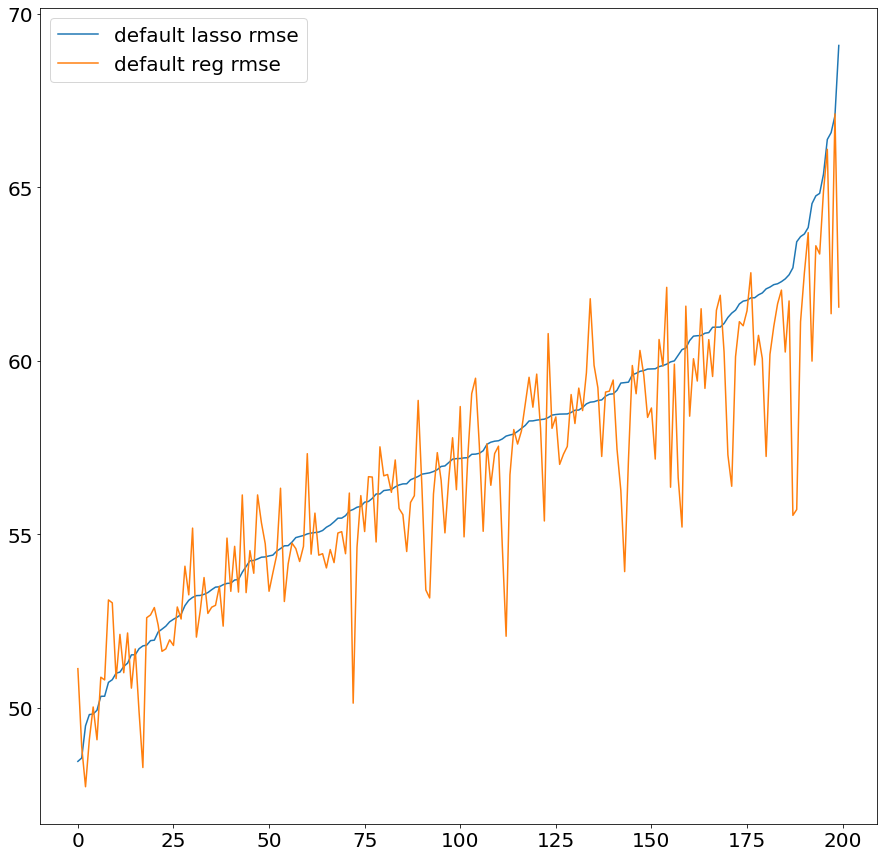

In [212]:
#!L
plt.rcParams.update({ 'figure.figsize' : (15, 15), 'font.size' : 20 })
plt.clf()
lasso_score = logs['default']['test lasso rmse'].to_numpy()
reg_score = logs['default']['test reg rmse'].to_numpy()
ids = np.argsort(lasso_score)
plt.plot(lasso_score[ids], label='default lasso rmse')
plt.plot(reg_score[ids], label='default reg rmse')
plt.legend()
plt.show()

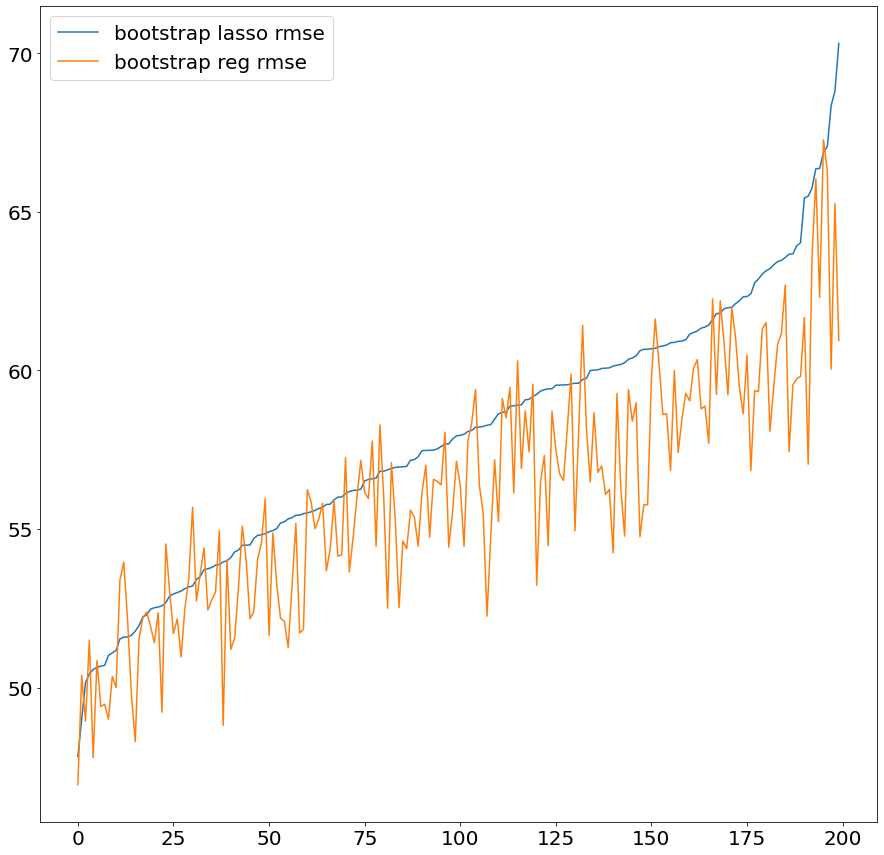

In [214]:
#!L
plt.rcParams.update({ 'figure.figsize' : (15, 15), 'font.size' : 20 })
plt.clf()
lasso_score = logs['bootstrap']['test lasso rmse'].to_numpy()
reg_score = logs['bootstrap']['test reg rmse'].to_numpy()
ids = np.argsort(lasso_score)
plt.plot(lasso_score[ids], label='bootstrap lasso rmse')
plt.plot(reg_score[ids], label='bootstrap reg rmse')
plt.legend()
plt.show()

In [222]:
#!L
np.percentile(logs['bootstrap']['test reg rmse'] - logs['bootstrap']['test lasso rmse'] - 
             (logs['default']['test reg rmse'] - logs['default']['test lasso rmse']), 50)

-1.2102962749705064

In [209]:
#!L
for first_key, first_log in logs.items():
    lasso_score = first_log['test lasso rmse']
    reg_score = first_log['test reg rmse']
    corr = stats.pearsonr(lasso_score, reg_score)[0]
    print((first_key, corr))

('~LightGBM', 0.887962135114443)
('bootstrap', 0.8741389919732995)
('default', 0.887962135114443)
('empty', 0.8957359407753134)


In [229]:
#!L
def compare_frequencies(freqs_1, freqs_2, splits, first_model_name, second_model_name):
    assert freqs_1.shape == freqs_2.shape
    variances = defaultdict(lambda: [])
    for i, (train_inds, val_inds, test_inds) in enumerate(splits):
        variances[('train', 1)].append(freqs_1[i, train_inds].var())
        variances[('train', 2)].append(freqs_2[i, train_inds].var())
        variances[('val', 1)].append(freqs_1[i, val_inds].var())
        variances[('val', 2)].append(freqs_2[i, val_inds].var())
        variances[('test', 1)].append(freqs_1[i, test_inds].var())
        variances[('test', 2)].append(freqs_2[i, test_inds].var())

    for key, value in variances.items():
        variances[key] = np.array(value)

    for key in ['train', 'val', 'test']:
        print(f'Comparing variances of inverse frequencies (on \'{key}\' subset)')
        print(f'First set mean variance: {variances[(key, 1)].mean()}')
        print(f'Second set mean variance: {variances[(key, 2)].mean()}')
        p = stats.wilcoxon(variances[(key, 1)], variances[(key, 2)], alternative='less')[1]
        print(f'Wilcoxon test p-value (H0: median of \'{first_model_name}\' - \'{second_model_name}\' > 0) {p}')

In [227]:
#!L
splits = load_from_pickle(get_pickle_dump_path('diabetes_splits'))
default_freqs = load_from_pickle(get_pickle_dump_path('default_freqs'))
bootstrap_freqs = load_from_pickle(get_pickle_dump_path('bootstrap_freqs'))

In [275]:
#!L
sum(map(len, splits[0]))

442

/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'list'> with size: 1000
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}


In [273]:
#!L
np.sum(default_freqs[0])

442


572.0

/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'list'> with size: 1000
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}


In [231]:
#!L
compare_frequencies(default_freqs, bootstrap_freqs, splits[:200], 'default', 'bootrstap')

Comparing variances of inverse frequencies (on 'train' subset)
First set mean variance: 14.031580413625608
Second set mean variance: 2.281565553406799
Wilcoxon test p-value (H0: median of 'default' - 'bootrstap' > 0) 1.0
Comparing variances of inverse frequencies (on 'val' subset)
First set mean variance: 7.123442605756281
Second set mean variance: 1.9806022477053609
Wilcoxon test p-value (H0: median of 'default' - 'bootrstap' > 0) 1.0
Comparing variances of inverse frequencies (on 'test' subset)
First set mean variance: 7.81348309098504
Second set mean variance: 2.285723203288263
Wilcoxon test p-value (H0: median of 'default' - 'bootrstap' > 0) 1.0


In [284]:
#!L
import warnings
warnings.filterwarnings('ignore')

In [285]:
#!L
def _parse_weights_line(line):
    tokens = line.replace(os.linesep, '').split(',')
    return np.array(list(map(np.float, tokens)))

def load_weights_diffs(filename):
    with open(filename, 'r') as weights_file:
        lines = list(weights_file.readlines())
    n = len(lines) // 2
    diffs = np.zeros(n, dtype=np.float)
    for i in range(n):
        regressor_weights = _parse_weights_line(lines[2 * i + 1])
        lasso_weights = _parse_weights_line(lines[2 * i + 2])
        diffs[i] = np.mean(np.abs(regressor_weights - lasso_weights))
            
    return diffs

In [286]:
#!L
default_diffs = load_weights_diffs(os.path.join(LOGS_PATH, 'weights_default_argset_diffs.log'))
bootstrap_diffs = load_weights_diffs(os.path.join(LOGS_PATH, 'weights_bootstrap_argset_diffs.log'))

In [289]:
#!L
p = stats.wilcoxon(default_diffs, bootstrap_diffs, alternative='less')[1]
print(f'Wilcoxon test p-value (H0: median of \'default diffs\' - \'bootstrap diffs\' > 0) {p}')

Wilcoxon test p-value (H0: median of 'default diffs' - 'bootstrap diffs' > 0) 1.0


In [234]:
#!L
LOG_FILENAMES = {
    '~LightGBM' : 'fioxed_LightGBM_argset_diffs',
    'bernoulli bootstrap' : 'fixed_bernoulli_bootstrap_argset_diffs',
    'bootstrap' : 'fixed_bootstrap_argset_diffs',
    'default' : 'fixed_default_argset_diffs',
    'border count 32' : 'fixed_diabetes_border_count_32_argset_diffs',
    'border count 64' : 'fixed_diabetes_border_count_64_argset_diffs',
    'border count 96' : 'fixed_diabetes_border_count_96_argset_diffs',
    'empty' : 'fixed_diabetes_border_count_96_argset_diffs',
}

logs = {name : load_log(filename) for name, filename in LOG_FILENAMES.items()}

In [261]:
#!L
results = []
for key in sorted(logs.keys()):
    results.append([])
    for other_key in sorted(logs.keys()):
        results[-1].append(stats.pearsonr(logs[key]['test reg rmse'] - logs[key]['test lasso rmse'], 
                                          logs[other_key]['test reg rmse'] - logs[other_key]['test lasso rmse'])[0])
results = np.array(results)

In [262]:
#!L
wilcoxon_ps = []
for first_key, first_log in logs.items():
    for second_key, second_log in logs.items():
        if first_key != second_key:
            first_diff = first_log['test reg rmse'] - first_log['test lasso rmse']
            second_diff = second_log['test reg rmse'] - second_log['test lasso rmse']
            if not np.any(np.array(first_diff) - np.array(second_diff)):
                wilcoxon_ps.append((first_key, second_key, 'EQUAL', 'EQUAL', 'EQUAL'))
                continue
            p_zero = stats.wilcoxon(first_diff, second_diff, alternative='two-sided')[1]
            p_greater = stats.wilcoxon(first_diff, second_diff, alternative='less')[1]
            p_less = stats.wilcoxon(first_diff, second_diff, alternative='greater')[1]
            wilcoxon_ps.append((first_key, second_key, p_zero, p_greater, p_less))

In [270]:
#!L
print(os.linesep.join([str(res[4]) for res in wilcoxon_ps]))

1.104429148267528e-07
1.9163494297447192e-10
EQUAL
0.3871557064196387
0.6332326868279776
0.9094386982623224
0.9094386982623224
0.9999998895570852
0.06654474580826278
0.9999998895570852
0.999999999570966
0.9999999926070726
0.9999999969743005
0.9999999969743005
0.9999999998083651
0.9334552541917372
0.9999999998083651
0.9999999999971437
0.9999999999889487
0.9999999999991296
0.9999999999991296
EQUAL
1.104429148267528e-07
1.9163494297447192e-10
0.3871557064196387
0.6332326868279776
0.9094386982623224
0.9094386982623224
0.6128442935803613
4.290340111607449e-10
2.8562667248757283e-12
0.6128442935803613
0.5451733367341699
0.9583116917216317
0.9583116917216317
0.3667673131720224
7.392927422355071e-09
1.1051273267636657e-11
0.3667673131720224
0.4548266632658301
0.9141231681458977
0.9141231681458977
0.09056130173767757
3.025699503918553e-09
8.704588704413077e-13
0.09056130173767757
0.04168830827836829
0.08587683185410228
EQUAL
0.09056130173767757
3.025699503918553e-09
8.704588704413077e-13
0.0905

In [296]:
#!L
monomials_lognames = [('diabetes_monomials_number_bootstrap_2', 'bootstrap_2'), ('diabetes_monomials_number_bootstrap_3', 'bootstrap_3'), ('diabetes_monomials_number_bootstrap_4', 'bootstrap_4'),
                      ('diabetes_monomials_number_defalt_2', 'default_2'), ('diabetes_monomials_number_defalt_3', 'default_3'), ('diabetes_monomials_number_defalt_4', 'default_4')]
monomials_logs = {key_name: load_log(name) for name, key_name in monomials_lognames}

In [298]:
#!L
monomials_logs['bootstrap_2'].head()

,#depth,#trees,#monomials,#non-zero monmials
0,2,5000,3160,3122
1,2,4977,3176,3155
2,2,4994,3297,3263
3,2,4999,3273,3234
4,2,5000,3314,3280


In [307]:
#!L
for depth in [2, 3, 4]:
    print(f'Depth: {depth}')
    
    print('Bootstrap mean #trees: ', np.mean(monomials_logs[bootstrap_key]['#trees']))
    print('Default mean #trees: ', np.mean(monomials_logs[default_key]['#trees']))
    
    p = stats.wilcoxon(monomials_logs[bootstrap_key]['#trees'], monomials_logs[default_key]['#trees'])[1]
    print(f'#trees equality p-value: {p}')
    
    bootstrap_key = f'bootstrap_{depth}'
    default_key = f'default_{depth}'
    
    mm = np.mean(monomials_logs[bootstrap_key]['#monomials'])
    mmnz = np.mean(monomials_logs[bootstrap_key]['#non-zero monmials'])
    print(f'Bootstrap: mean monomials number: {mm}; mean non-zero monomials number: {mmnz}')
    
    mm = np.mean(monomials_logs[default_key]['#monomials'])
    mmnz = np.mean(monomials_logs[default_key]['#non-zero monmials'])
    print(f'Default: mean monomials number: {mm}; mean non-zero monomials number: {mmnz}')
    
    p = stats.wilcoxon(monomials_logs[bootstrap_key]['#monomials'], monomials_logs[default_key]['#monomials'], alternative='less')[1]
    print(f'Wilcoxon test p-value (H0: #monomials median of \'bootstrap\' - \'default\' > 0) {p}')
    p = stats.wilcoxon(monomials_logs[bootstrap_key]['#non-zero monmials'], monomials_logs[default_key]['#non-zero monmials'], alternative='less')[1]
    print(f'Wilcoxon test p-value (H0: #non-zero monmials median of \'bootstrap\' - \'default\' > 0) {p}')

Depth: 2
Bootstrap mean #trees:  4959.04
Default mean #trees:  4795.65
#trees equality p-value: 1.3334361754539165e-11
Bootstrap: mean monomials number: 3183.995; mean non-zero monomials number: 3153.495
Default: mean monomials number: 162.66; mean non-zero monomials number: 161.565
Wilcoxon test p-value (H0: #monomials median of 'bootstrap' - 'default' > 0) 1.0
Wilcoxon test p-value (H0: #non-zero monmials median of 'bootstrap' - 'default' > 0) 1.0
Depth: 3
Bootstrap mean #trees:  4933.21
Default mean #trees:  4289.225
#trees equality p-value: 1.3713261442527634e-25
Bootstrap: mean monomials number: 12122.81; mean non-zero monomials number: 11885.65
Default: mean monomials number: 409.99; mean non-zero monomials number: 402.575
Wilcoxon test p-value (H0: #monomials median of 'bootstrap' - 'default' > 0) 1.0
Wilcoxon test p-value (H0: #non-zero monmials median of 'bootstrap' - 'default' > 0) 1.0
Depth: 4
Bootstrap mean #trees:  4857.14
Default mean #trees:  4615.985
#trees equality p-v